# 선형 회귀 모델을 위한 데이터 변환
---

선형 회귀 모델은 학습에 사용되는 `피처`와 예측값인 `타겟` 간에 선형 관계가 있다고 가정하는 ML 모델입니다. 따라서 선형 회귀 모델은 이 둘 간의 최적의 선형함수를 도출하는 것으로 타겟값을 예측하게 됩니다.

우리가 선형 회귀 모델을 사용하기 전에 데이터 변환이 필요한 이유는 이러한 **선형 회귀 모델은 피처와 타겟값이 정규 분포 형태임을 기대**하기 때문입니다. 

따라서 피처 혹은 타겟값이 정규 분포를 따르지 않는 **왜곡(Skew)된 형태의 분포를 가질 경우 모델의 성능이 떨어질 수 있어 모델이 데이터를 학습하기 전 데이터 변환 작업이 선행**되어야 합니다.

그렇다면 어떤 방법을 이용해 데이터 변환을 수행해야 할까요?


대표적으로 아래의 3가지 방법을 이용해 보다 나은 성능을 위한 데이터 변환 작업을 수행합니다.

1. **StandardScaler**를 이용해 평균이 0, 분산이 1인 가우시안 정규분포를 가진 데이터 세트로 변환하는 표준화를 진행하거나 **MinMaxScaler**를 이용해 최솟값이 0이고 최댓값이 1인 정규화 수행

`Standardization`

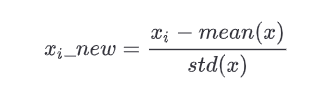

`Normalization`

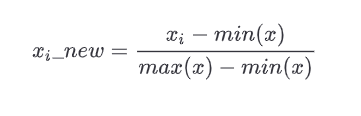

2. **스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용**

3. 원래 값에 **log 함수를 적용**해 보다 정규분포에 가까운 형태로 값을 변환(Log Transformation)

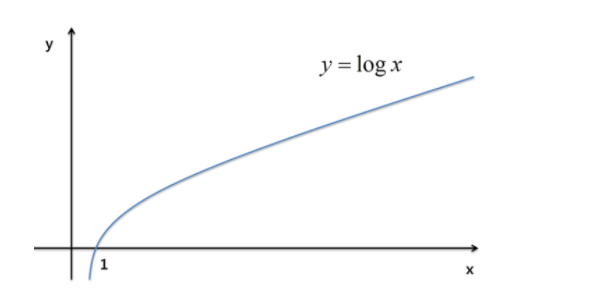

log 함수 적용의 원리는 위 로그 그래프를 보면 이해할 수 있습니다. 위 그래프를 통해 x축 변화량에 따른 y축 변화량이 작아지는 것을 확인할 수 있는데 이처럼 **큰 수를 같은 비율의 작을 수로 변환**하는 역할을 통해 평차가 큰 특성에 정규성을 높일 수 있습니다.

또한 **np.log1p() 함수를 이용해 로그 변환을 수행한 피처에 지수함수인 np.expm1() 함수를 이용해 원복**하는 것이 가능하기 때문에 Log 변환을 주로 사용합니다. 

이미지 출처 : https://hwi-doc.tistory.com/entry/%ED%94%BC%EC%B3%90-%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81-Feature-Scaling

Boston 주택 가격 데이터를 이용해 실제 데이터 스케일링을 통해 선형 회귀 모델이 학습할 데이터를 변환 했을 때 성능에 어떤 변화가 있는지 알아보겠습니다.

In [1]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# boston 데이터 세트 로드

bst = load_boston()

bstDF = pd.DataFrame(bst.data, columns = bst.feature_names)

# boston 데이터 세트의 Target은 주택 가격

bstDF['PRICE'] = bst.target

# 선형회귀 모델 생성을 위한 라이브러리 임포트
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 학습에 사용할 데이터 준비
y_target = bstDF['PRICE']
X_data = bstDF.drop(['PRICE'], axis=1, inplace=False)

# train, test 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state = 156)

In [4]:
# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE와 회귀 계수 반환
def get_linear_reg_eval(model_name, params=None, X_data_n = None, y_target_n=None,
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name, '#######')
    for param in params:
        if model_name == 'Ridge' : model = Ridge(alpha=param)
        elif model_name == 'Lasso' : model = Lasso(alpha=param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,
                                        y_target_n, scoring='neg_mean_squared_error', cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        
        print('alpha {0} 일 때 5 폴드의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
            
        # cross_val_score는 evaluation metric만 반환, 모델을 다시 학습해 회귀 계수 반환
            
        model.fit(X_data_n, y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 series로 변환, 이를 DF 칼럼으로 추가
            coeff = pd.Series(data=model.coef_, index = X_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname] = coeff
    return coeff_df

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# method는 Standard, MinMax, Log
# p_degree는 다항식 특성 추가 시 사용, 2 이상 부여 X

def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
        
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree = p_degree,
                                        include_bias=False).fit_transform(scaled_data)
    return scaled_data

In [6]:
# Ridge의 alhpa 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 반환

alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환, 먼저 원본 그대로, 표준정규분포, 표준정규분포 + 다항식 특성
# 최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2),
                ('MinMax',None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                   input_data=X_data)
    
    print('\n##변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    
    get_linear_reg_eval('Ridge', params=alphas, X_data_n = X_data_scaled,
                       y_target_n = y_target, verbose=False, return_coeff=False)


##변환 유형:None, Polynomial Degree:None
alpha 0.1 일 때 5 폴드의 평균 RMSE : 5.788
alpha 1 일 때 5 폴드의 평균 RMSE : 5.653
alpha 10 일 때 5 폴드의 평균 RMSE : 5.518
alpha 100 일 때 5 폴드의 평균 RMSE : 5.330

##변환 유형:Standard, Polynomial Degree:None
alpha 0.1 일 때 5 폴드의 평균 RMSE : 5.826
alpha 1 일 때 5 폴드의 평균 RMSE : 5.803
alpha 10 일 때 5 폴드의 평균 RMSE : 5.637
alpha 100 일 때 5 폴드의 평균 RMSE : 5.421

##변환 유형:Standard, Polynomial Degree:2
alpha 0.1 일 때 5 폴드의 평균 RMSE : 8.827
alpha 1 일 때 5 폴드의 평균 RMSE : 6.871
alpha 10 일 때 5 폴드의 평균 RMSE : 5.485
alpha 100 일 때 5 폴드의 평균 RMSE : 4.634

##변환 유형:MinMax, Polynomial Degree:None
alpha 0.1 일 때 5 폴드의 평균 RMSE : 5.764
alpha 1 일 때 5 폴드의 평균 RMSE : 5.465
alpha 10 일 때 5 폴드의 평균 RMSE : 5.754
alpha 100 일 때 5 폴드의 평균 RMSE : 7.635

##변환 유형:MinMax, Polynomial Degree:2
alpha 0.1 일 때 5 폴드의 평균 RMSE : 5.298
alpha 1 일 때 5 폴드의 평균 RMSE : 4.323
alpha 10 일 때 5 폴드의 평균 RMSE : 5.185
alpha 100 일 때 5 폴드의 평균 RMSE : 6.538

##변환 유형:Log, Polynomial Degree:None
alpha 0.1 일 때 5 폴드의 평균 RMSE : 4.770
alpha 1 일 때 5 폴드의 평균 RMSE 

위 결과를 확인하면 각 변환 유형에 따른 alpha 별 5폴드의 평균 RMSE를 확인할 수 있는데 Boston 주택 가격 데이터의 경우 일반적인 Standard Scaler나 Min Max Scaler사용 시 RMSE의 변화는 미미한 것으로 보여집니다.

하지만 **Scaler 사용 후 다항식을 적용한 결과 성능 개선**을 보였습니다. 

이처럼 2번 Scaling 방법인 1차 데이터 변환 후 다항식을 적용하는 방법으로 성능 개선을 기대할 수 있지만 **이 경우 피처가 많을 경우 적용하기 어렵고 학습 수행시간이 길어진다는 단점**이 존재합니다.

마지막으로 **Log 스케일링을 적용한 결과 다항식을 적용하지 않고도 눈에 띄게 개선된 성능을 확인**할 수 있습니다.